In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns

import dask

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [2]:
import graphufs

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [4]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [5]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    
    xds["valid_time"] = xds.time + xds.lead_time
    xds = xds.set_coords("valid_time")
    return xds

In [6]:
start_date = "2022-07-19T00"
end_date = "2022-07-21T00"

dates = pd.date_range(
    start_date,
    end_date,
    freq="3h",
)

In [7]:
varlist = [
    "tmp",
    "ugrd",
    "vgrd",
    "dzdt",
    "spfh",
    "tmp2m",
    "pressfc",
    "ugrd10m",
    "vgrd10m",
    "prateb_ave",
]

In [8]:
ufs2era = {
    "tmp": "temperature",
    "ugrd": "u_component_of_wind",
    "vgrd": "v_component_of_wind",
    "dzdt": "vertical_velocity",
    "spfh": "specific_humidity",
    "tmp2m": "2m_temperature",
    "pressfc": "surface_pressure",
    "ugrd10m": "10m_u_component_of_wind",
    "vgrd10m": "10m_v_component_of_wind",
    "prateb_ave": "total_precipitation",
}

In [9]:
selected_levels = [50, 100, 500, 850, 1000]

Grab Replay

In [10]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

In [11]:
rds = rds[varlist]
rds = rds.sel(time=dates)
rds = rds.sel(pfull=selected_levels, method="nearest")

In [12]:
rds.nbytes / 1e9

2.40650078

In [13]:
%%time
rds = rds.load();

CPU times: user 1min 25s, sys: 15.7 s, total: 1min 41s
Wall time: 1min 42s


In [14]:
rds = rds.rename({
    "grid_yt": "lat",
    "grid_xt": "lon",
    "pfull": "level",
})

Grab predictions

In [15]:
gds = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr/")
#gdm = open_zarr("/p1-evaluation/gdm-v1/validation/graphufs_gdm.240h.zarr/")

In [16]:
gds = gds.sel(time=slice(start_date, end_date))
gds = gds.sel(level=selected_levels, method="nearest")
gds = gds.load()

Grab ERA5

In [17]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era[[ufs2era[v] for v in varlist]].sel(
    time=dates,
    level=selected_levels,
).load()
era = era.rename({
    "latitude": "lat",
    "longitude": "lon",
    **{v: k for k, v in ufs2era.items()},
})

Grab statistics

In [18]:
stats = {}
for key in ["mean", "stddev", "diffs_stddev"]:
    stats[key] = xr.open_zarr(
        f"gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.statistics.1993-2019/{key}_by_level.zarr",
        storage_options={"anon": "true"},
    )
    stats[key] = stats[key][varlist]
    stats[key] = stats[key].sel(pfull=selected_levels, method="nearest")
    stats[key] = stats[key].rename({"pfull": "level"})
    stats[key] = stats[key].load()
    

## Plot distribution of values...

In [19]:
def histplot(gkey, levels=(50, 100, 500, 1000), show_nnz=False, do_diff=False, sharey=False, do_log=False):
    ekey = ufs2era[gkey]
    
    ncols = len(levels)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*3, 4), constrained_layout=True, sharey=sharey)
    
    for level, ax in zip(levels, axs):

        all_the_data = {}
        for data, label, time_dim in zip(
            [era, gds, rds, rds.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))],
            ["ERA5", "GraphUFS", "Replay", "Replay Subsampled"],
            ["time", "fhr", "time", "time"],
        ):
            local = data[gkey].sel(level=level, method="nearest", drop=True).copy()
            if gkey == "tmp":
                local -= 273.15
            if do_log:
                local = np.log(local)
            if do_diff:
                local = local.diff(time_dim)

            if do_diff and not do_log:
                local = local / stats["diffs_stddev"]
                
            all_the_data[label] = local.values.flatten()
            
        sns.violinplot(
            all_the_data,
            ax=ax,
            cut=0,
        )
        if show_nnz:
            ax.axhline(y=0, color="gray", alpha=.5)
            negative = {key: np.sum(val < 0) for key, val in all_the_data.items()}
            ax.set(
                xticks=ax.get_xticks(),
                xticklabels = [f"{key}\n({val})" for key,val in negative.items()]
            )
            
        ax.set(title=f"~{int(level)} hPa")
    fig.suptitle(ekey.replace("_"," ").capitalize())
    return fig, axs

In [28]:
def histplot_2d(gkey, show_nnz=False, do_diff=False, sharey=False, do_log=False):
    ekey = ufs2era[gkey]
    
    fig, ax= plt.subplots(1, 1, figsize=(3, 4), constrained_layout=True)

    all_the_data = {}
    for data, label, time_dim in zip(
        [era, gds, rds, rds.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))],
        ["ERA5", "GraphUFS", "Replay", "Replay Subsampled"],
        ["time", "fhr", "time", "time"],
    ):
        local = data[gkey].copy()
        if gkey == "tmp":
            local -= 273.15
        if do_log:
            local = np.log(local)
        if do_diff:
            local = local.diff(time_dim)

        if do_diff and not do_log:
            local = local / stats["diffs_stddev"][gkey]
            
        all_the_data[label] = local.values.flatten()
            
    sns.violinplot(
        all_the_data,
        ax=ax,
        cut=0,
    )
    if show_nnz:
        ax.axhline(y=0, color="gray", alpha=.5)
        negative = {key: np.sum(val < 0) for key, val in all_the_data.items()}
        ax.set(
            xticks=ax.get_xticks(),
            xticklabels = [f"{key}\n({val})" for key,val in negative.items()]
        )
        
    ax.set(title=ekey.replace("_"," ").capitalize())
    return fig, ax

CPU times: user 31min 22s, sys: 4min 15s, total: 35min 37s
Wall time: 30min 42s


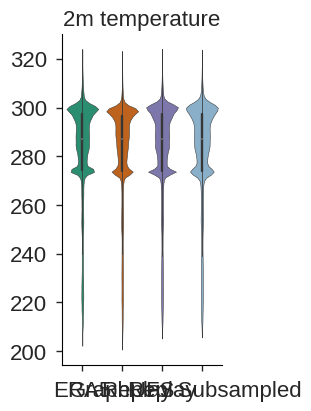

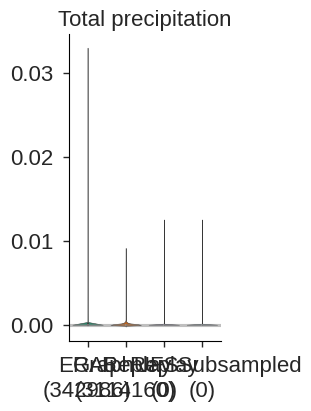

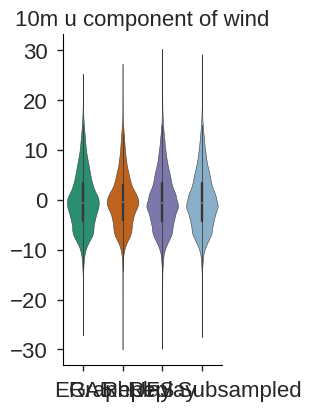

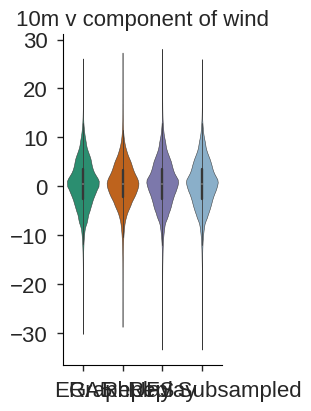

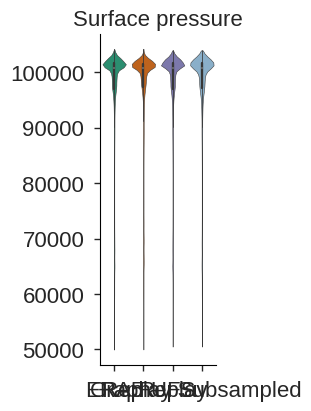

In [21]:
%%time
for key in ["tmp2m", "prateb_ave", "ugrd10m", "vgrd10m", "pressfc"]:
    show_nnz = key == "prateb_ave"
    histplot_2d(key, show_nnz=show_nnz)

CPU times: user 30min 37s, sys: 4min 50s, total: 35min 27s
Wall time: 30min 32s


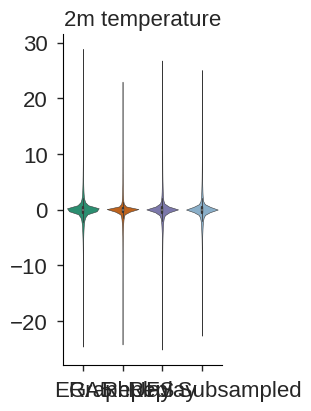

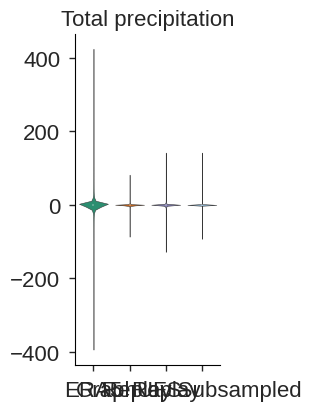

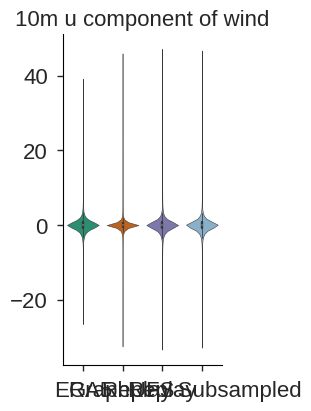

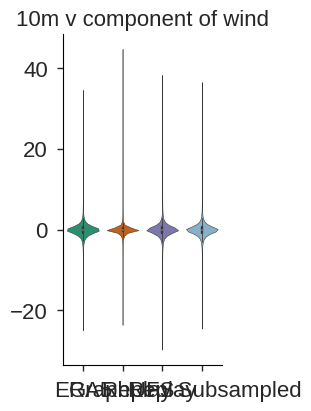

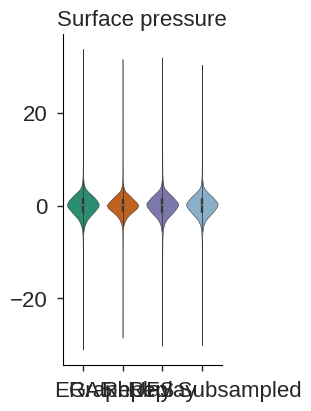

In [30]:
%%time
for key in ["tmp2m", "prateb_ave", "ugrd10m", "vgrd10m", "pressfc"]:
    histplot_2d(key, show_nnz=False, do_diff=True)

/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


CPU times: user 5min 32s, sys: 57.9 s, total: 6min 30s
Wall time: 5min 31s


(<Figure size 300x400 with 1 Axes>,
 <Axes: title={'center': 'Total precipitation'}>)

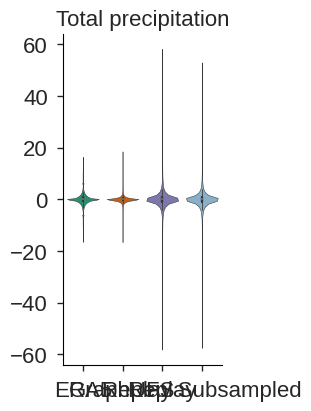

In [31]:
%%time
histplot_2d("prateb_ave", show_nnz=False, do_diff=True, do_log=True)

In [ ]:
%%time
for key in ["tmp", "spfh", "ugrd", "vgrd", "dzdt"]:
    show_nnz = key == "spfh"
    histplot(key, show_nnz=show_nnz)

TypeError: cannot add a Dataset to a Variable in-place

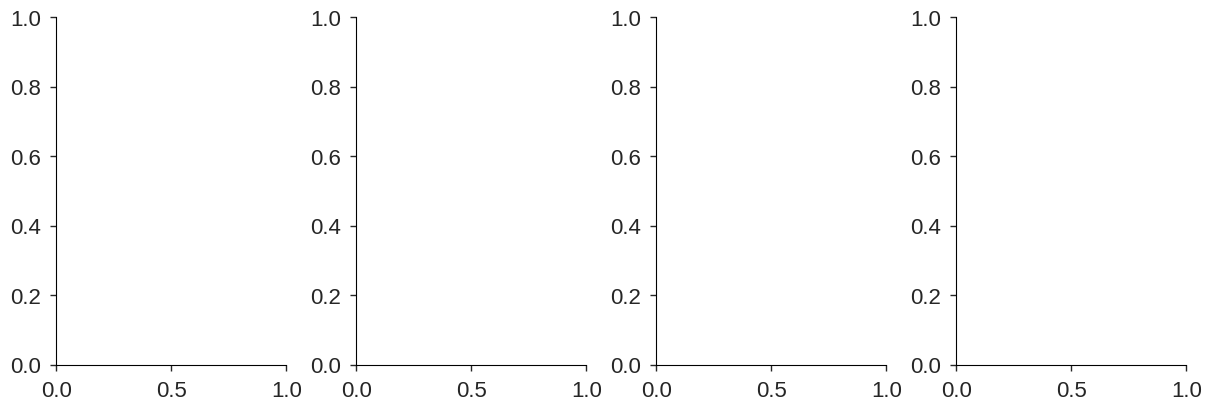

In [25]:
%%time
for key in ["tmp", "spfh", "ugrd", "vgrd", "dzdt"]:
    show_nnz = key == "spfh"
    do_log = key == "spfh"
    histplot(key, show_nnz=show_nnz, do_diff=True, do_log=do_log)

AttributeError: PolyCollection.set() got an unexpected keyword argument 'showfliers'

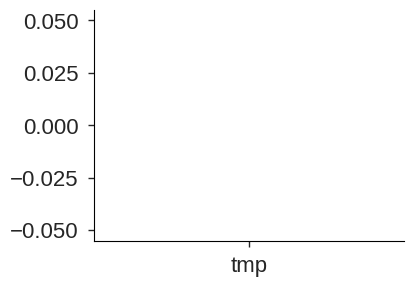

In [43]:
%%time
sns.violinplot(
    rds[["tmp"]].isel(level=0).to_dataframe(),
    showfliers=False,
)

CPU times: user 9min 32s, sys: 12.9 s, total: 9min 45s
Wall time: 9min 26s


<Axes: >

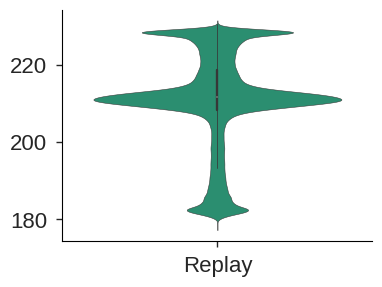

In [48]:
%%time
sns.violinplot(
    {"Replay": rds["tmp"].isel(level=0).values.flatten()},
    gridsize=1000,
)

CPU times: user 5min 1s, sys: 31.5 s, total: 5min 32s
Wall time: 4min 53s


<Axes: >

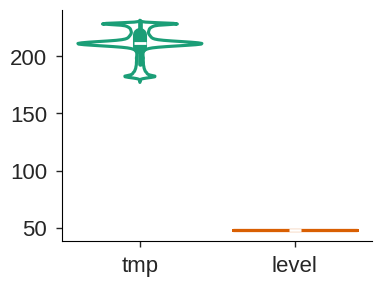

In [45]:
%%time
sns.violinplot(
    rds[["tmp"]].isel(level=0).to_dataframe(),
    fill=False,
)

<timed eval>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


CPU times: user 3min 44s, sys: 17.7 s, total: 4min 2s
Wall time: 3min 42s


<Axes: ylabel='Density'>

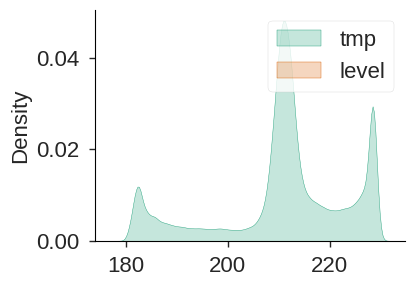

In [46]:
%%time
sns.kdeplot(
    rds[["tmp"]].isel(level=0).to_dataframe(),
    fill=True,
)

In [ ]:
%%time
sns.vio

## Temperature

CPU times: user 5min 2s, sys: 28 s, total: 5min 30s
Wall time: 3min 58s


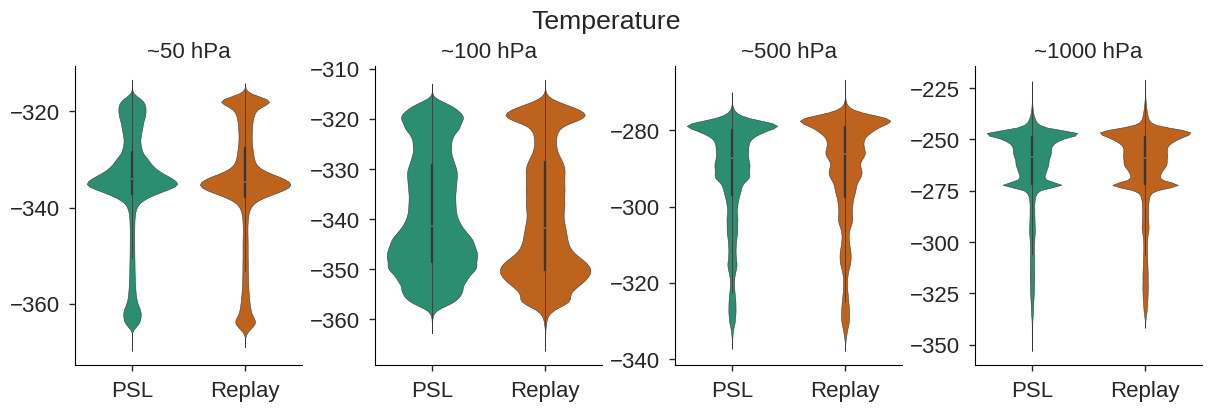

In [18]:
%%time
histplot("tmp", "temperature");

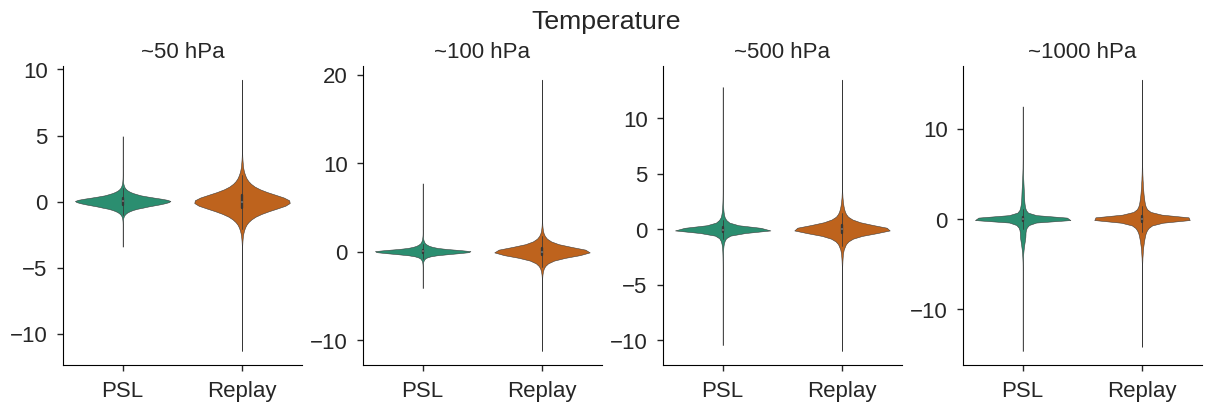

In [19]:
histplot("tmp", "temperature", do_diff=True);

## Humidity

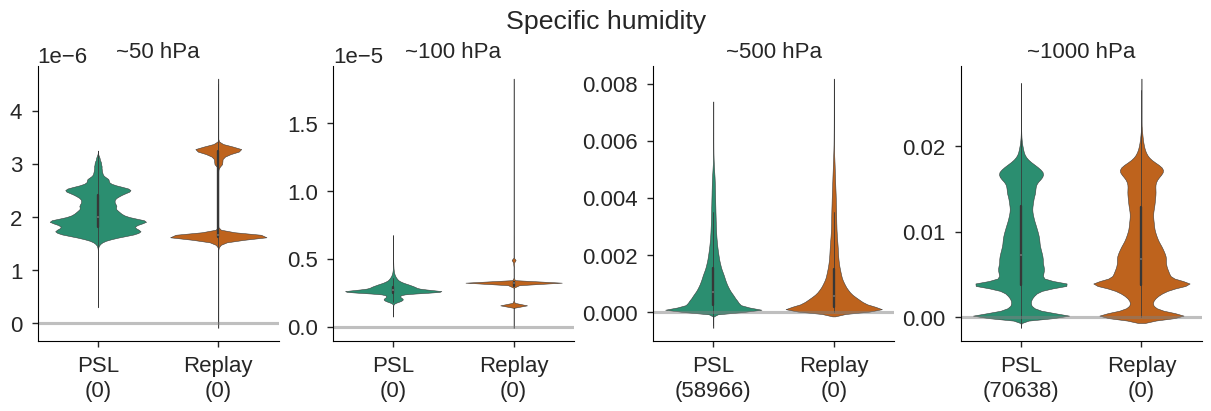

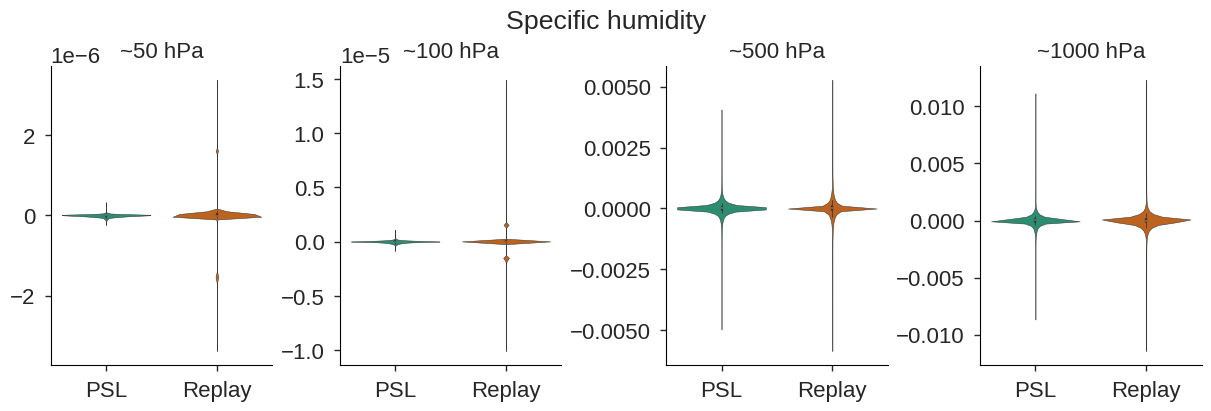

In [20]:
histplot("spfh", "specific_humidity", show_nnz=True);
fig, axs = histplot("spfh", "specific_humidity", show_nnz=False, do_diff=True);

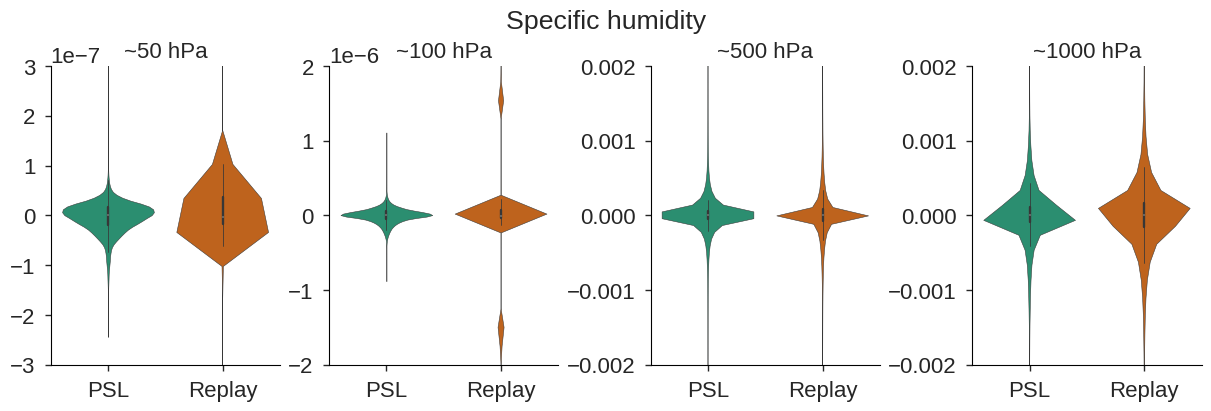

In [21]:
axs[0].set(ylim=[-3e-7, 3e-7])
axs[1].set(ylim=[-2e-6, 2e-6])
axs[2].set(ylim=[-2e-3, 2e-3])
axs[3].set(ylim=[-2e-3, 2e-3])
fig

/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


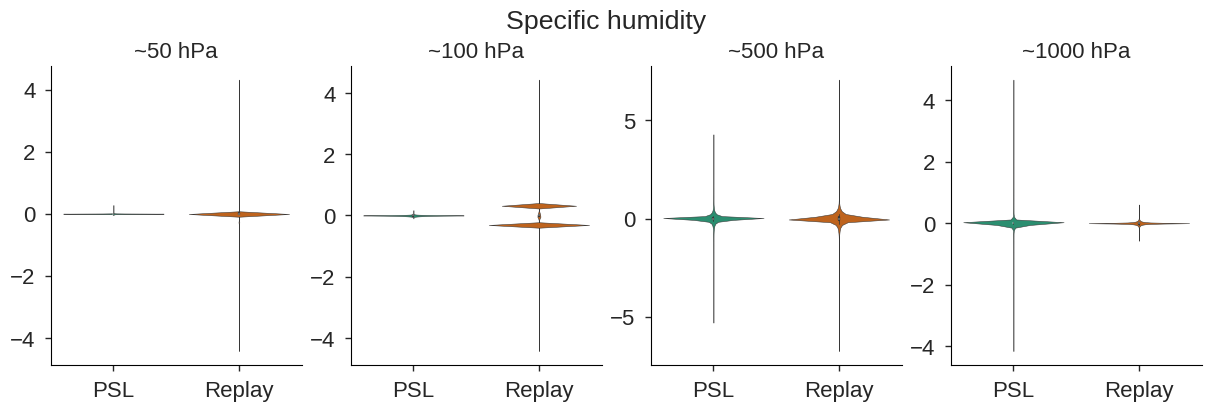

In [22]:
fig, axs = histplot("spfh", "specific_humidity", show_nnz=False, do_diff=True, do_log=True);

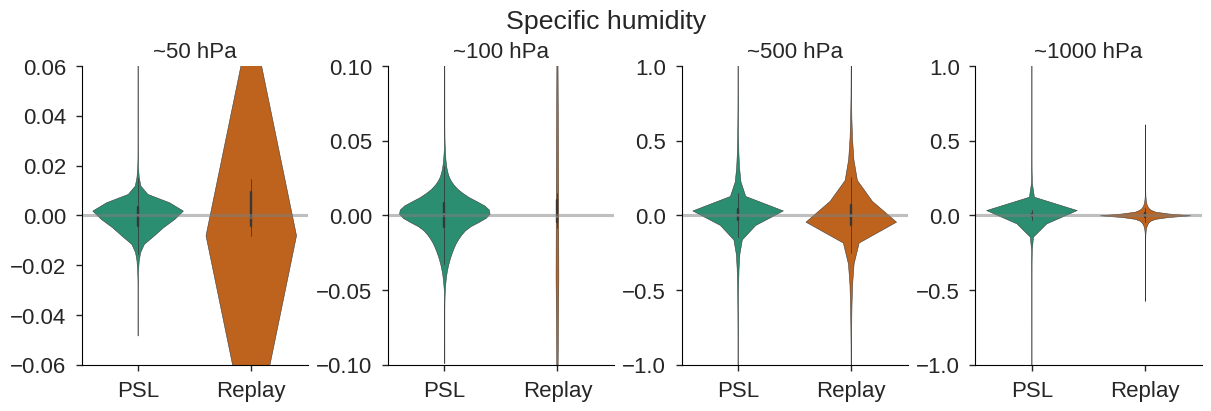

In [23]:
axs[0].set(ylim=[-.06, .06])
axs[1].set(ylim=[-.1, .1])
axs[2].set(ylim=[-1, 1])
axs[3].set(ylim=[-1, 1])
[ax.axhline(y=0, color='gray', alpha=.5) for ax in axs]
fig

## Zonal Wind

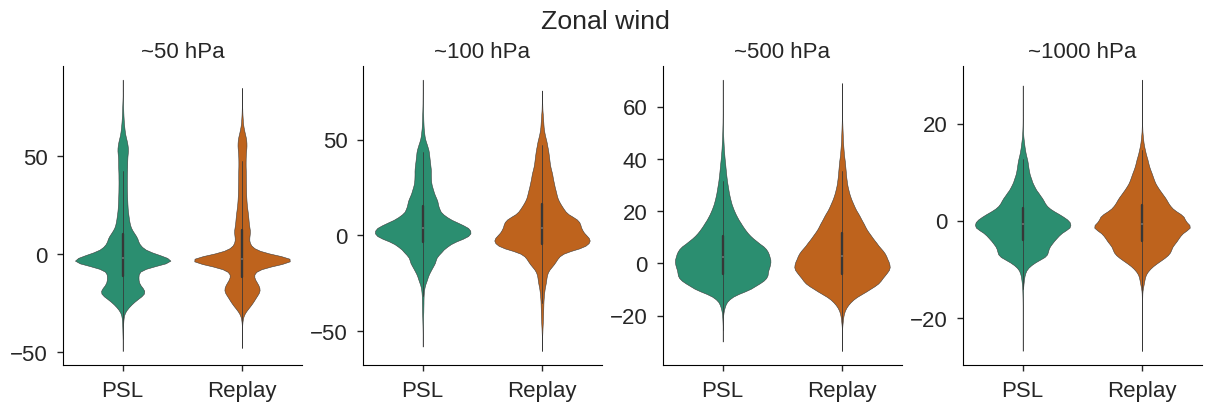

In [27]:
histplot("ugrd", "Zonal Wind");

In [ ]:
histplot("ugrd", "Zonal Wind", do_diff=True);


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x2b727000bec0> (for post_execute), with arguments args (),kwargs {}:


## Meridional Wind

In [ ]:
histplot("vgrd", "Meridional Wind");

In [ ]:
histplot("vgrd", "Meridional Wind", do_diff=True);

## Vertical Velocity

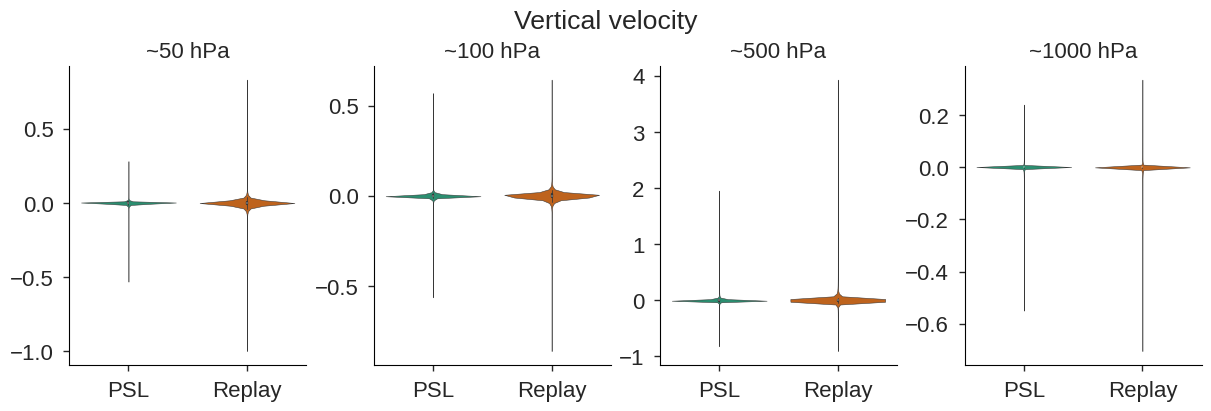

In [24]:
histplot("dzdt", "vertical_velocity");

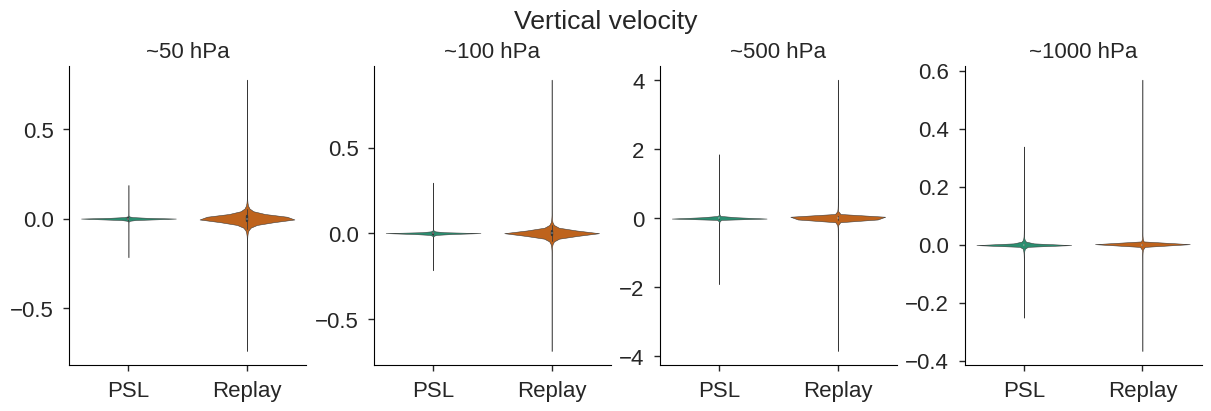

In [25]:
histplot("dzdt", "vertical_velocity", do_diff=True);